# *VAE-Based Latent Representation and Classification*

>Mohammad Sarhangzadeh <br>
>Mahyar Fardinfar


In [1]:
import torch
import torchvision.datasets  as dsets
import torch.utils.data
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import torch.optim as optim

import tqdm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix


c:\Users\msarh\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 512
num_epochs = 300
train_batch_size = 16
val_batch_size = 16

## *dataset load & transform*

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(image_size),
        transforms.RandomRotation((-15,+15)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(image_size),
        transforms.Normalize(0,1),
    ]),
    'validation': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(image_size),
        transforms.RandomRotation((-15,+15)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(image_size),
        transforms.Normalize(0,1),
    ]),
}

train_dataset = dsets.ImageFolder(root="dataset/train", transform=data_transforms['train'])
validation_dataset = dsets.ImageFolder(root="dataset/val", transform=data_transforms['validation'])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=val_batch_size, shuffle=False)

In [4]:
train_batch = next(iter(train_dataloader))
val_batch = next(iter(validation_dataloader))

print("Training Batch Shape:", train_batch[0].shape)  
print("Training Labels Shape:", train_batch[1].shape)

print("Validation Batch Shape:", val_batch[0].shape)
print("Validation Labels Shape:", val_batch[1].shape)

Training Batch Shape: torch.Size([16, 3, 512, 512])
Training Labels Shape: torch.Size([16])
Validation Batch Shape: torch.Size([16, 3, 512, 512])
Validation Labels Shape: torch.Size([16])


#### *training images*

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(train_batch[0], padding=2).cpu(),(1,2,0)))

#### *Validation images*

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(val_batch[0], padding=2).cpu(),(1,2,0)))

## *models*

In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=2048):
        return input.view(input.size(0), size, 1, 1)

In [6]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=2048, z_dim=36):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels,16,kernel_size=3, stride=2, padding=1),#256
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),#127
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),#62
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),#30
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),#14
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2),#6
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, kernel_size=4, stride=2),#2
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            Flatten()
        )
        
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2sigma = nn.Linear(h_dim, z_dim)
        self.z2h = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(), #1
            nn.ConvTranspose2d(h_dim, 512, kernel_size=5, stride=2), #5
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2),#12
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2), #28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2), #61
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2), #126
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=6, stride=2),#256
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, image_channels, kernel_size=3, stride=2, padding=1, output_padding=1),#512
            nn.BatchNorm2d(image_channels),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size(),device=device)
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu = self.h2mu(h)
        logvar = self.h2sigma(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def encode(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def decode(self, z):
        return self.decoder(self.z2h(z))
    
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.z2h(z)
        return self.decoder(z), mu, logvar

In [7]:
def vae_loss(recon_x, x, mu, logvar) -> float:
    BCE = F.binary_cross_entropy(recon_x.view(-1, image_size*image_size*3),
                                 x.view(-1, image_size*image_size*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return [KLD, BCE ,BCE + KLD]

## *VAE training*

In [8]:
model = VAE().to(device)
try :
    model.load_state_dict(torch.load('vae_size_512.pth'))
except :
    print('weights not found')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for epoch in range(num_epochs):
    train_loss = 0
    for data, _ in tqdm.tqdm(train_dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        info = vae_loss(recon_batch, data, mu, logvar)
        loss = info[2]
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    torch.save(model.state_dict(), "vae_size_512.pth")
    avg_train_loss = train_loss / len(train_dataloader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Total Loss: {loss.item():.4f}, '
          f'KLD Loss: {info[0].item():.4f}, '
          f'Reconstruction Loss: {info[1].item():.4f}, '
          f'Average Train Loss: {avg_train_loss:.4f}')
model.eval()


## *VAE results*

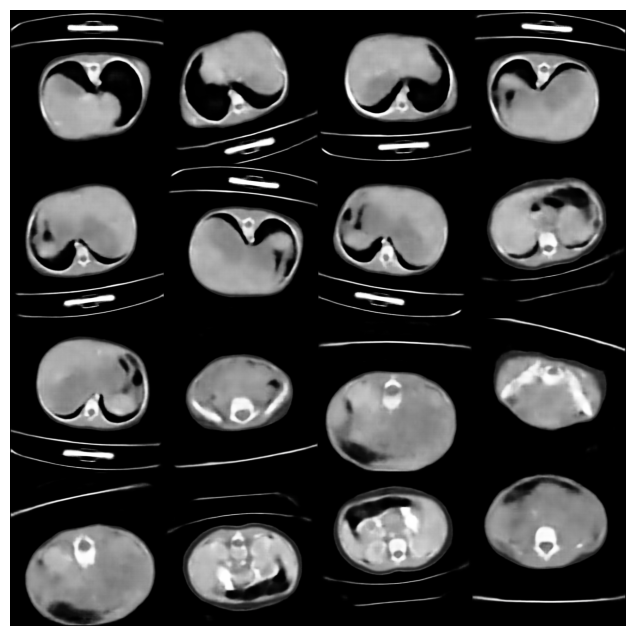

In [9]:
# Ensure the model and data are on the same device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)

try:
    model.load_state_dict(torch.load('vae_size_512.pth'))
except FileNotFoundError:
    print("Weights not found ):")

# Ensure the validation batch is moved to the same device
val_batch = next(iter(validation_dataloader))
val_batch_data, _ = val_batch
val_batch_data = val_batch_data.to(device)  # Move validation batch to the same device

decoded_batch = model.decode(model.encode(val_batch_data).data).data

grid = vutils.make_grid(decoded_batch.cpu(), nrow=4, padding=2)

# Plot the grid
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()

In [ ]:
decoded_batch = model.decode(model.encode(val_batch[0]).data).data
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch, padding=2).cpu(),(1,2,0)))

#### *visualize latent*

In [ ]:
import torch
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

model.eval()
latents = []
labels = []

with torch.no_grad():
    for data, label in validation_dataloader:
        data = data.to(device)
        z = model.encode(data)
        latents.append(z.cpu())  # Move to CPU
        labels.append(label)

latents = torch.cat(latents)
labels = torch.cat(labels)

latents_np = latents.numpy()  # Convert to NumPy array

pca = TSNE(n_components=2)
latents_2d = pca.fit_transform(latents_np)

# Optionally, you can visualize the 2D embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10')  # Adjust cmap as needed
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Latent Space')
plt.show()


In [ ]:
model.eval()
latents = []
labels = []

with torch.no_grad():
    for data, label in validation_dataloader:
        data = data.to('cpu')
        z = model.encode(data)
        latents.append(z.cpu())
        labels.append(label.cpu())

latents = torch.cat(latents)
labels = torch.cat(labels)

pca = TSNE(n_components=2)
latents_2d = pca.fit_transform(latents)

In [ ]:
plt.figure(figsize=(10, 8))

scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='viridis', s=5, alpha=0.8)

plt.colorbar(scatter, label='Class Label')

plt.title('Latent Space Visualization of Validation Dataset')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()


## *MLP training*

In [10]:
model = VAE().to(device)
model.load_state_dict(torch.load('vae_size_512.pth'))
model.eval()

train_latents = []
train_labels = []

with torch.no_grad():
    for data, label in tqdm.tqdm(train_dataloader):
        data = data.to(device)
        z = model.encode(data)
        train_latents.append(z)
        train_labels.append(label)

train_latents = torch.cat(train_latents)
train_labels = torch.cat(train_labels)

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


In [11]:
model.eval()
val_latents = []
val_labels = []

with torch.no_grad():
    for data, label in tqdm.tqdm(validation_dataloader):
        data = data.to(device)
        z = model.encode(data)
        val_latents.append(z)
        val_labels.append(label)

val_latents = torch.cat(val_latents)
val_labels = torch.cat(val_labels)

100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


In [14]:
X_train, y_train = (train_latents, train_labels)
print(f"Length of X_train: {len(X_train)}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Length of y_train: {len(y_train)}")
print(f"Shape of y_train: {y_train.shape}")

Length of X_train: 1062
Shape of X_train: torch.Size([1062, 36])
Length of y_train: 1062
Shape of y_train: torch.Size([1062])


In [15]:
X_val, y_val = (val_latents, val_labels)
print(f"Length of X_train: {len(X_val)}")
print(f"Shape of X_train: {X_val.shape}")
print(f"Length of y_train: {len(y_val)}")
print(f"Shape of y_train: {y_val.shape}")

Length of X_train: 132
Shape of X_train: torch.Size([132, 36])
Length of y_train: 132
Shape of y_train: torch.Size([132])


In [16]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim,128),
            nn.LeakyReLU(0.2),
            nn.Linear(128,128),
            nn.LeakyReLU(0.2),
            nn.Linear(128,output_dim)
        )
        
    def forward(self, x):
        x = self.mlp(x)
        return x

In [17]:
input_dim = train_latents.shape[1] 
output_dim = len(train_dataset.classes)

mlp = MLP(input_dim, output_dim).to(device)
mlp_criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp.parameters(), lr=1e-3)

## *MLP results*

In [ ]:
num_epochs = 300
for epoch in range(num_epochs):
    mlp.train()
    mlp_optimizer.zero_grad()
    outputs = mlp(X_train.to(device))
    loss = mlp_criterion(outputs, y_train.to(device))
    loss.backward()
    mlp_optimizer.step()
    
    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(X_val.to(device))
        _, predicted = torch.max(val_outputs, 1)
        y_val_cpu = y_val.to(device)  # Ensure this is on the same device

        val_accuracy = (predicted == y_val_cpu).sum().item() / y_val_cpu.size(0)
        precision = precision_score(y_val_cpu.cpu(), predicted.cpu(), average='weighted')
        recall = recall_score(y_val_cpu.cpu(), predicted.cpu(), average='weighted')
        f1 = f1_score(y_val_cpu.cpu(), predicted.cpu(), average='weighted')

        
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, '
          f'Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    
print(classification_report(predicted.cpu() , y_val))
print(confusion_matrix(predicted.cpu(), y_val))

In [18]:
train_latent_reshaped = train_latents.view(-1, 1, 6, 6)
val_latent_reshaped = val_latents.view(-1, 1, 6, 6)
print(train_latent_reshaped.shape)

print(f"Length of train_latent_train: {len(train_latent_reshaped)}")
print(f"Length of train_latent_train: {len(val_latent_reshaped)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Shape of y_val: {len(y_val)}")

torch.Size([1062, 1, 6, 6])
Length of train_latent_train: 1062
Length of train_latent_train: 132
Length of y_train: 1062
Shape of y_val: 132


In [ ]:
import torch 
from torch import nn 


class PatchEmbedding(nn.Module):
    def __init__(self, img_size, img_channel, patch_size, embed_dim, dropout):
        super().__init__()
        
        assert img_size % patch_size == 0, 'image size should be divisible by patch size'
        num_patches = (img_size // patch_size) ** 2
        
        self.patcher = nn.Sequential(
            nn.Conv2d(in_channels=img_channel, 
                      out_channels=embed_dim,
                      kernel_size=patch_size,
                      stride=patch_size,
                      padding=0),
            nn.Flatten(2)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim),requires_grad=True)     
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim),requires_grad=True)        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        batch_size = x.shape[0]
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.position_embedding
        x = self.dropout(x)
        
        return x

In [ ]:
import torch
from torch import nn 

class ViTEncoder(nn.Module):
    def __init__(self, embed_dim, n_head, dropout):
        super().__init__()
        
        assert embed_dim%n_head==0, 'embedding dimensions should be divisible by number of heads'
        
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim , embed_dim*4),
            nn.GELU(),
            nn.Linear(embed_dim*4, embed_dim)
        )
        self.attention = nn.MultiheadAttention(embed_dim, n_head, dropout,batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):     
        attention, _  = self.attention(x, x, x)
        x = x + self.dropout(attention)
        x = self.norm1(x)
        mlp_out = self.mlp(x)
        x = x + self.dropout(mlp_out)
        x = self.norm2(x)
        
        return x
        

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, img_channel, patch_size, embed_dim, n_head, depth, dropout, num_classes):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, img_channel, patch_size, embed_dim, dropout)
        self.encoder = nn.Sequential(
            *[ViTEncoder(embed_dim, n_head, dropout) for _ in range(depth)]
        )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.encoder(x)
        cls_token = x[:,0]
        out = self.mlp_head(cls_token)
        
        return out


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img_size = 6 
img_channel = 1
patch_size = 3
embed_dim = (patch_size ** 2) * img_channel
n_head = 9
depth = 7
dropout = 0.01
num_classes = 3

batch_size = 4
learning_rate = 0.002
num_epochs = 300


vit = VisionTransformer(img_size, img_channel, patch_size, embed_dim, n_head, depth, dropout, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    vit.train()
    optimizer.zero_grad()
    
    outputs = vit(train_latent_reshaped.to(device))
    loss = criterion(outputs, y_train.to(device))
    
    loss.backward()
    optimizer.step()
    
    vit.eval()
    with torch.no_grad():
        val_outputs = vit(val_latent_reshaped.to(device))
        _, predicted = torch.max(val_outputs, 1)
        
        val_accuracy = (predicted == val_labels.to(device)).sum().item() / val_labels.size(0)
        precision = precision_score(val_labels.cpu(), predicted.cpu(), average='weighted')
        recall = recall_score(val_labels.cpu(), predicted.cpu(), average='weighted')
        f1 = f1_score(val_labels.cpu(), predicted.cpu(), average='weighted')
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, '
          f'Recall: {recall:.4f}, F1 Score: {f1:.4f}')


In [ ]:
vit.eval()
with torch.no_grad():
    val_outputs = vit(val_latent_reshaped.to(device))
    _, predicted = torch.max(val_outputs, 1)
        
    temp = 0
    val_accuracy = (predicted == val_labels.to(device)).sum().item() / val_labels.size(0)
    precision = precision_score(val_labels.cpu(), predicted.cpu(), average='weighted')
    recall = recall_score(val_labels.cpu(), predicted.cpu(), average='weighted')
    f1 = f1_score(val_labels.cpu(), predicted.cpu(), average='weighted')
    if f1 > temp :
        torch.save(model.state_dict(), "final_vit.pth")

        
print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
    f'Validation Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, '
    f'Recall: {recall:.4f}, F1 Score: {f1:.4f}')

In [ ]:
torch.save(vit.state_dict(), "vit1.pth")


In [ ]:
print(y_val)
print(predicted)

In [ ]:
print(classification_report(predicted.detach().cpu() , y_val))
print(confusion_matrix(predicted.detach().cpu() , y_val))

In [28]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 3 * 3, 256) 
        self.fc2 = nn.Linear(256, 256) 
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc4(x)
        return x


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, criterion, val_data, val_labels):
    """
    Evaluates the model on the validation data.
    
    Args:
        model: The trained model to evaluate.
        criterion: Loss function to compute the validation loss.
        val_data: Validation data (latent representations).
        val_labels: True labels for the validation data.
    
    Returns:
        A dictionary containing the validation loss, accuracy, precision, recall, and F1 score.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Move validation data to the device
        val_data = val_data.to(device)
        val_labels = val_labels.to(device)

        # Perform forward pass
        val_outputs = model(val_data)
        val_loss = criterion(val_outputs, val_labels)

        # Calculate metrics
        _, predicted = torch.max(val_outputs, 1)
        val_accuracy = (predicted == val_labels).sum().item() / val_labels.size(0)
        precision = precision_score(val_labels.cpu(), predicted.cpu(), average='weighted')
        recall = recall_score(val_labels.cpu(), predicted.cpu(), average='weighted')
        f1 = f1_score(val_labels.cpu(), predicted.cpu(), average='weighted')

    # Return metrics as a dictionary
    return {
        'val_loss': val_loss.item(),
        'val_accuracy': val_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training loop
cnn_model = CNNClassifier().to(device)
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)

num_epochs = 300
for epoch in range(num_epochs):
    cnn_model.train()
    
    # Move the inputs and targets to the device
    train_latent_reshaped = train_latent_reshaped.to(device)
    y_train = y_train.to(device)
    
    cnn_optimizer.zero_grad()
    outputs = cnn_model(train_latent_reshaped)
    loss = cnn_criterion(outputs, y_train)
    loss.backward()
    cnn_optimizer.step()
    
    # Evaluate the model
    metrics = evaluate_model(cnn_model, cnn_criterion, val_latent_reshaped, val_labels)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
          f'Validation Loss: {metrics["val_loss"]:.4f}, Validation Accuracy: {metrics["val_accuracy"]:.4f}, '
          f'Precision: {metrics["precision"]:.4f}, Recall: {metrics["recall"]:.4f}, F1 Score: {metrics["f1"]:.4f}')

# Additional evaluation after training
final_metrics = evaluate_model(cnn_model, cnn_criterion, val_latent_reshaped, val_labels)
print('Final Evaluation Metrics:')
print(f'Validation Loss: {final_metrics["val_loss"]:.4f}')
print(f'Validation Accuracy: {final_metrics["val_accuracy"]:.4f}')
print(f'Precision: {final_metrics["precision"]:.4f}')
print(f'Recall: {final_metrics["recall"]:.4f}')
print(f'F1 Score: {final_metrics["f1"]:.4f}')


c:\Users\msarh\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\msarh\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\msarh\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\User

Epoch [1/300], Loss: 1.0934, Validation Loss: 1.0455, Validation Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1 Score: 0.3333
Epoch [2/300], Loss: 1.0456, Validation Loss: 1.0691, Validation Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1 Score: 0.3333
Epoch [3/300], Loss: 1.0682, Validation Loss: 1.0313, Validation Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1 Score: 0.3333
Epoch [4/300], Loss: 1.0310, Validation Loss: 1.0366, Validation Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1 Score: 0.3333
Epoch [5/300], Loss: 1.0360, Validation Loss: 1.0346, Validation Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1 Score: 0.3333
Epoch [6/300], Loss: 1.0338, Validation Loss: 1.0224, Validation Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1 Score: 0.3333


c:\Users\msarh\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\msarh\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\msarh\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\User

Epoch [7/300], Loss: 1.0211, Validation Loss: 1.0010, Validation Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1 Score: 0.3333
Epoch [8/300], Loss: 0.9993, Validation Loss: 0.9763, Validation Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1 Score: 0.3333
Epoch [9/300], Loss: 0.9743, Validation Loss: 0.9580, Validation Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1 Score: 0.3333
Epoch [10/300], Loss: 0.9549, Validation Loss: 0.9257, Validation Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1 Score: 0.3333
Epoch [11/300], Loss: 0.9208, Validation Loss: 0.8779, Validation Accuracy: 0.5303, Precision: 0.5078, Recall: 0.5303, F1 Score: 0.3943
Epoch [12/300], Loss: 0.8701, Validation Loss: 0.8332, Validation Accuracy: 0.6364, Precision: 0.7895, Recall: 0.6364, F1 Score: 0.5585
Epoch [13/300], Loss: 0.8198, Validation Loss: 0.7772, Validation Accuracy: 0.7045, Precision: 0.8143, Recall: 0.7045, F1 Score: 0.6696
Epoch [14/300], Loss: 0.7540, Validation Loss: 0.69

In [ ]:

# Move tensors to CPU and convert to numpy arrays
predicted_np = predicted.cpu().numpy()
y_val_np = y_val.cpu().numpy()

# Print classification report and confusion matrix
print(classification_report(y_val_np, predicted_np))
print(confusion_matrix(y_val_np, predicted_np))


In [36]:
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert the PyTorch tensors to NumPy arrays for scikit-learn compatibility
train_features_flattened = X_train.cpu().numpy()
val_features_flattened = X_val.cpu().numpy()
train_labels = y_train.cpu().numpy()
val_labels = y_val.cpu().numpy()

# Initialize SVM classifier
svm_classifier = svm.SVC(kernel='linear', C=1.0)

# Train SVM classifier
svm_classifier.fit(train_features_flattened, train_labels)

# Predict on validation data
val_predictions = svm_classifier.predict(val_features_flattened)

# Calculate evaluation metrics
val_accuracy = accuracy_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
f1 = f1_score(val_labels, val_predictions, average='weighted')

# Print evaluation metrics
print('SVM Evaluation Metrics:')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


SVM Evaluation Metrics:
Validation Accuracy: 0.8030
Precision: 0.8057
Recall: 0.8030
F1 Score: 0.8034
